In [1]:
import numpy as np
import pandas as pd

# Importing the Datasets
train = pd.read_csv('readonly/train.csv', encoding="ISO-8859-1", low_memory=False)
test = pd.read_csv('readonly/test.csv', encoding="ISO-8859-1", low_memory=False)

In [2]:
# Columns that are shared between two dataframes
desired_columns = ['inspector_name', 'zip_code', 'fine_amount', 
                   'admin_fee', 'state_fee', 'late_fee']

# Train column
train_columns = desired_columns + ['compliance']

# Columns for onehotencorder
onehot_columns = ['inspector_name', 'zip_code']

# Will be used in the final result as index
result_index = test.loc[:, 'ticket_id']

# Creating view of the existing DataFrame
train = train.loc[:, train_columns]
test = test.loc[:, desired_columns]

In [3]:
### Data cleaning

# Dropping NA or empty values
train.replace('nan', np.nan)
train.dropna(subset=desired_columns + ['compliance'], inplace=True)

# zip_code contained multiple zipcodes that werenot 
# corresponding to our requirements, hence, have been dropped.
train = train[train['zip_code'].str.len() == 5]
train = train[train['zip_code'].str.startswith('48')]

# fine_amount contained multiple missentries of *10 or /10, this is normalizing those errors
train['fine_amount'] = train['fine_amount'].apply(lambda x: x/10 if x>1000 else x)
train['fine_amount'] = train['fine_amount'].apply(lambda x: x*10 if x<10 else x)

for column in desired_columns:
    print(column, 'Q1 is:\t', train[column].value_counts().sort_values(ascending=False).quantile(0.25))
    print(column, 'mean is:\t', train[column].value_counts().sort_values(ascending=False).mean())
    print(column, 'Q3 is:\t', train[column].value_counts().sort_values(ascending=False).quantile(0.75))
    print()


inspector_name Q1 is:	 19.5
inspector_name mean is:	 895.0251572327044
inspector_name Q3 is:	 1025.0

zip_code Q1 is:	 2.0
zip_code mean is:	 290.4265306122449
zip_code Q3 is:	 113.5

fine_amount Q1 is:	 1.0
fine_amount mean is:	 4907.206896551724
fine_amount Q3 is:	 2941.0

admin_fee Q1 is:	 142309.0
admin_fee mean is:	 142309.0
admin_fee Q3 is:	 142309.0

state_fee Q1 is:	 142309.0
state_fee mean is:	 142309.0
state_fee Q3 is:	 142309.0

late_fee Q1 is:	 2.0
late_fee mean is:	 4312.393939393939
late_fee Q3 is:	 2780.0



late_fee       7.191793
compliance     3.258489
fine_amount    2.789244
zip_code       2.207884
admin_fee      0.000000
state_fee      0.000000
dtype: float64


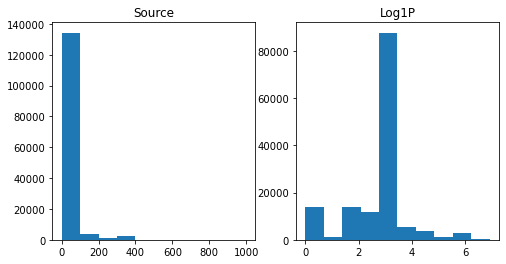

Log1P results for late_fee: -0.7829471160991703


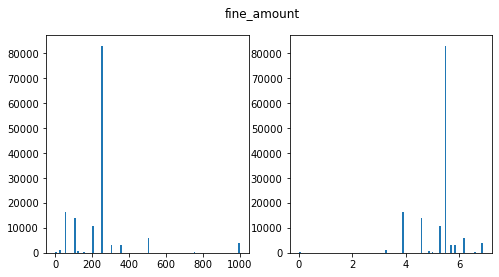

In [4]:
# Analyzing the data, attempting to find an improvements that can be made on the data

print(train.skew().sort_values(ascending=False))

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(train['late_fee'])
ax2.hist(train['late_fee'].apply(np.log1p))
ax1.set(title='Source'), ax2.set(title='Log1P')
plt.show()

# Log1p provides us with much better skew

print("Log1P results for late_fee:", train['late_fee'].apply(np.log1p).skew())

train['late_fee'] = train['late_fee'].apply(np.log1p)

# train['fine_amount'] = train['fine_amount'].apply(np.log1p)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(train['fine_amount'],bins=100)
ax2.hist(train['fine_amount'].apply(np.log1p), bins=100) # -1.2315781045495866
fig.suptitle('fine_amount')
plt.show()

### ^ Unsatisfying result, no grave difference has been made

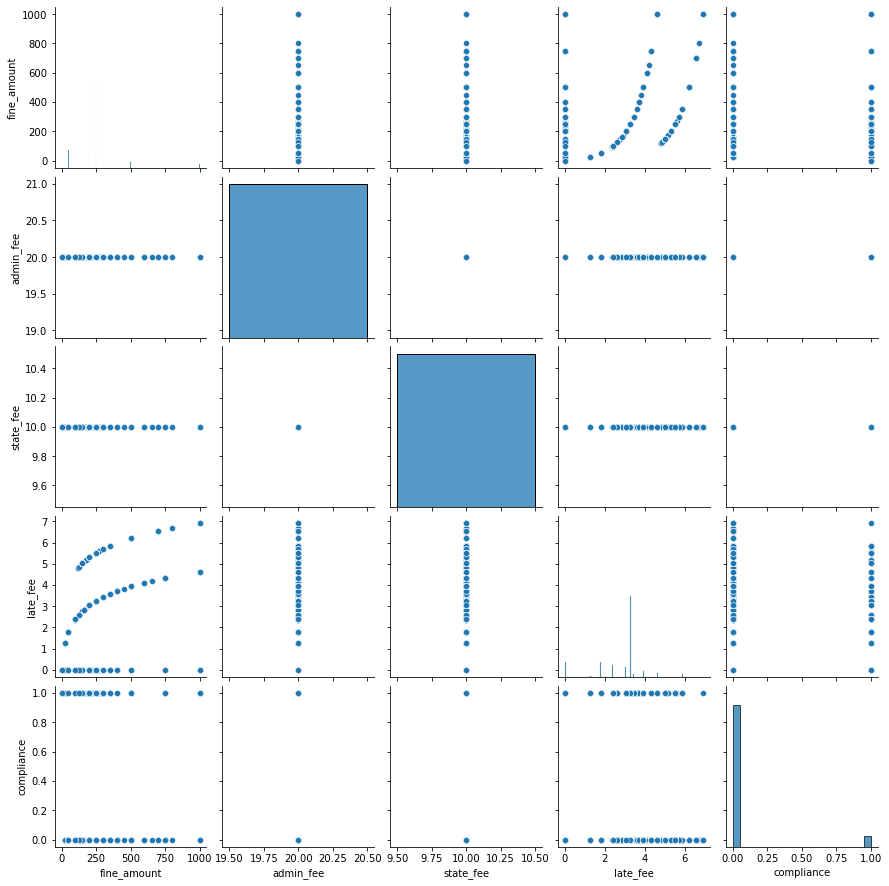

In [5]:
import seaborn as sns

# %store
sns.pairplot(train)

#### **Based on the graphical representation above we can see that there is no corellation between compliance and any of the numerical variables.**

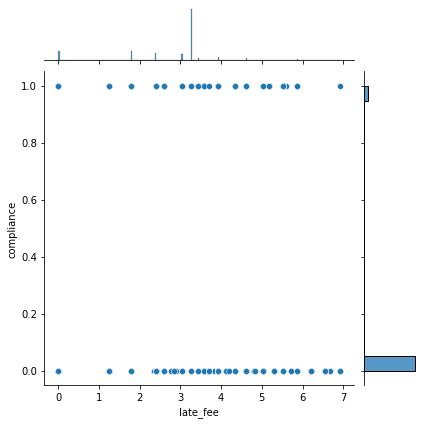

In [6]:
sns.jointplot(x=train['late_fee'], 
              y=train['compliance'])

Simple example demonstrating lack of correlation between the features and the target

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

X = train[desired_columns] # selecting our columns
y = train['compliance'] # target column

# Construction of make_column_transformer with specification of columns to be selected for OHE
columns_tran = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), onehot_columns), 
                                       remainder = 'passthrough')
# For clarification purposes seperated fit and transform, could of used fit_transform function
columns_tran.fit(X)
X = columns_tran.transform(X) 

X.todense()

matrix([[ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  4.33073334],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  4.33073334],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  2.39789527],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  4.61512052],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  3.93182563],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  0.        ]])

-0.36495523322650236


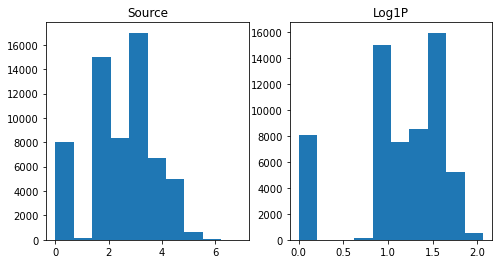

In [12]:
# Data cleaning our test dataset
test.fillna('missing_values', inplace=True)

print(test['late_fee'].skew())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(test['late_fee'])
ax2.hist(test['late_fee'].apply(np.log1p))
ax1.set(title='Source'), ax2.set(title='Log1P')
plt.show()

test['late_fee'] = test['late_fee'].apply(np.log1p)

In [13]:
# Transforming the dataset into OHE matrix
X_test = columns_tran.transform(test)

X_test.todense()

matrix([[ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  1.39736348],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  1.72546305],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  1.2231562 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  1.2231562 ],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  1.2231562 ],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  0.        ]])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20)

In [17]:
# Models

from sklearn.model_selection import GridSearchCV


# RandomForest
from sklearn.ensemble import RandomForestClassifier
clr = RandomForestClassifier(n_jobs=-1, random_state=0) # Bad result, confusion matrix result: [131760, 37], [9196, 1316]
# Previous calculations have been performed and the best depth resulted in being 20 and n_estimators of 100
# depth, n_estimators = [None, 1, 10, 20], [10, 50, 100, 500]
param = {'n_estimators': [200], 'max_depth': [20]} # RandomForest
grid_model = GridSearchCV(clr, param_grid=param, scoring='roc_auc')
grid_model.fit(X_train, y_train)
# Randomforest has been abandond to check for LinearSVC and see the results of it


### LinearSVC
# from sklearn.svm import LinearSVC
# clr = LinearSVC(C=0.1, max_iter=5000) # Worse result
# param = {'C': [0.1, 0.5, 1, 100], 'max_iter': [3000, 5000, 10000]}
# grid_model = GridSearchCV(clr, param_grid=param, scoring='roc_auc')
# grid_model.fit(X_train, y_train)
# # LinearSVC produced worse results: [131776,     21], [ 10253,    259]

### LogisticRegression
# from sklearn.linear_model import LogisticRegression
# clr = LogisticRegression()
# # param = {'C': [0.1, 0.5, 1, 100], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [5000]}
# param = {'C': [100], 'solver': ['saga'], 'max_iter': [5000]}
# grid_model = GridSearchCV(clr, param_grid=param, scoring='roc_auc')
# grid_model.fit(X_train, y_train)
# # LogisticRegression results: [131696, 101], [10389, 123]

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [20], 'n_estimators': [200]},
             scoring='roc_auc')

In [18]:
grid_model.score(X_validation, y_validation)

0.7958810398300216

^ Substantial result

In [19]:
# Saving the results of GriSearchCV

print('Best parameters: ', grid_model.best_params_)

with open('best_params.txt', 'a') as file:
    print('Best params for {} were: {}'.format(clr, grid_model.best_params_), file=file)

Best parameters:  {'max_depth': 20, 'n_estimators': 200}


In [20]:
# Load previously saved model:

# import pickle
# from pathlib import Path

# name = '' #input model name
# with open(Path().joinpath('ML_results', name), 'rb') as file:
#     grid_model1 = pickle.load(file)

In [21]:
from sklearn.metrics import confusion_matrix
from pathlib import Path

conf_mat = grid_model.predict(X_train)

confusion = confusion_matrix(y_train, conf_mat)

with open(Path().joinpath('ML_results', 'best_params.txt'), 'a') as file:
    conf_matrix = 'Confusion matrix: {}'.format(str(confusion).replace('\n', ' '))
    print(conf_matrix, file=file)
    if confusion[0, 0] < confusion[0, 1] or confusion[1, 0] > confusion[1, 1]:
        print('Unsatisfactory', file=file)
    print('\n', file=file)
    
confusion

array([[105395,      0],
       [  8304,    148]])

^ Confusion matrix result shows a high number of FN. 

In [22]:
# Saving the result
import pickle 

name = str(clr).replace('()', '')


with open(Path().joinpath('ML_results', name), 'wb') as file:
    pickle.dump(grid_model, file)

In [23]:
y_scores = grid_model.best_estimator_.predict_proba(X_test)
result = pd.DataFrame(y_scores[:, 1], index = result_index, columns = [f'{name} probablity'])

result

,"RandomForestClassifier(n_jobs=-1, random_state=0) probablity"
ticket_id,
284932,0.066737
285362,0.062732
285361,0.075754
285338,0.082027
285346,0.154963
...,...
376496,0.036644
376497,0.036644
376499,0.065795


In [24]:
result.mean()

RandomForestClassifier(n_jobs=-1, random_state=0) probablity    0.092884
dtype: float64